In [1]:
import pescador
import numpy as np
import keras
import pandas as pd
import torch
import os
import math
from kymatio.torch import Scattering1D
import sys
sys.path.append("../src")
import cnn
import test_training
import ftm_ver2 as ftm2
import hcqt
import soundfile as sf
from sklearn.preprocessing import MinMaxScaler
import random

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, AveragePooling1D, Conv2D, MaxPooling2D,ReLU,AveragePooling2D
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model #save and load models
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
import IPython.display as ipd
import librosa
import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)

2022-08-07 23:48:37.870658: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 23:48:37.871388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 23:48:37.895234: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 23:48:37.896115: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 23:48:37.896907: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

## visualize doce output

In [3]:
sys.path.append("../scripts")
import doce_exp

experiment = doce_exp.set()
selector = {"J":8,"Q":1}

(data, settings, header) = experiment.get(
  metric = '0',
  selector = selector,
  path = 'output'
  )

In [4]:
data,settings,header

([], [], '')

## load model and visualize output

In [3]:
import pickle
pkl_file =  "/home/han/data/drum_data/han2022features-pkl/scattering_o2/scattering_o2_fold-train_J-08_Q-16.pkl"
pkl_fl = open(pkl_file, 'rb')
Sy,y = pickle.load(pkl_fl)

In [4]:
from sys import getsizeof
Sy.shape,getsizeof(Sy)


((82224, 32, 437), 144)

In [5]:
Sy2,y2 = np.load(pkl_file,mmap_mode='r',allow_pickle=True)
getsizeof(Sy2[1])

NameError: name 'pkl_file' is not defined

In [12]:
Sy3,y3 = np.load(pkl_file,allow_pickle=True)
getsizeof(Sy3)

144

In [3]:
audio_path = "/home/han/data/drum_data/"
random_state=44000
batch_size=64
n_epoch=30
steps_per_epoch=50 

ftype="cqt"
J = 12
Q = 16
bs = batch_size
sr = 22050 
y_train,train_ids = test_training.load_gt("train")
y_test,test_ids = test_training.load_gt("test")
y_val,val_ids = test_training.load_gt("val")
#log scale w, p and D, normalize
y_train_normalized,y_val_normalized,y_test_normalized = test_training.preprocess_gt(y_train,y_val,y_test)

train_idx = np.arange(0,y_train.shape[0],1) #how long should this be?? #streamers to open


In [3]:
def plot_loss_curve(loss_path,title):
    loss = pd.read_csv(loss_path)
    plt.plot(loss["loss"],label="training loss")
    plt.plot(loss["val_loss"],label="validation loss")
    print("minimum loss",np.min(loss["loss"]),np.min(loss["val_loss"]),title)
    plt.title(title)
    plt.xlabel("epoch number")
    plt.ylabel("Loss")
    plt.legend()
   
def find_best_trial(exp):
    min_vals = []
    for trial in os.listdir(exp):
        loss = pd.read_csv(os.path.join(exp,trial,"training.log"))
        min_vals.append(min(loss["val_loss"]))
    min_min = min(min_vals)
    return os.listdir(exp)[min_vals.index(min_min)]


def yield_prediction(test_batches,ckpt_path,model):
    model.load_weights(ckpt_path)
    preds = model.predict(pescador.tuples(test_batches,'input','y'),steps=100,verbose=1)
    return preds

minimum loss 0.0284847263246774 0.0148019716143608 vqt J6
minimum loss 0.0226850733160972 0.0142623474821448 vqt J8
minimum loss 0.0386202447116375 0.0196311566978693 hcqt J6
minimum loss 0.0213712379336357 0.0172538254410028 hcqt J8
minimum loss 0.0197324063628911 0.0145277213305234 cqt J6
minimum loss 0.0195444040000438 0.0141789028421044 cqt J8


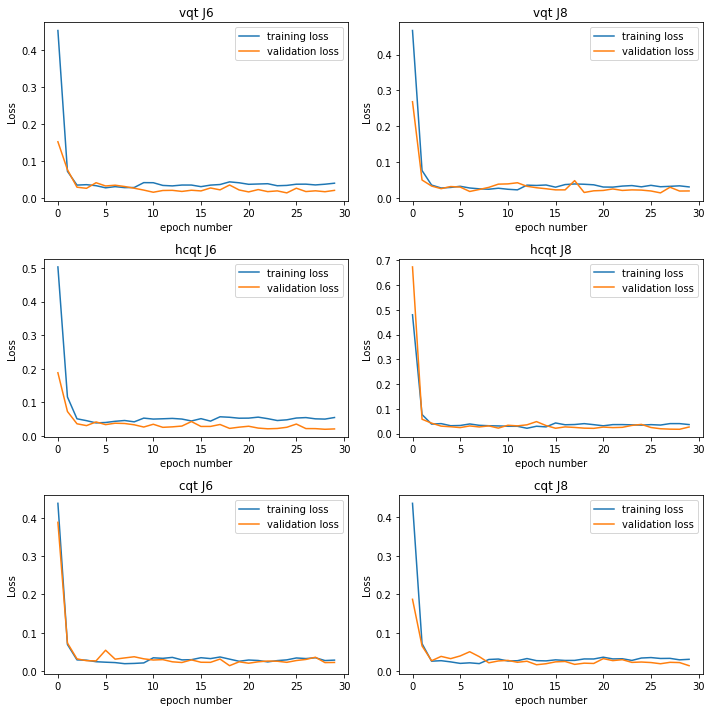

In [10]:
#compare and select optimum J, consider only linear activation, Q = 1
out_dir = "/home/han/wave2shape/output/doce/"
i = 1
plt.subplots(3,2,figsize=(10,10))
for f in ["vqt","hcqt","cqt"]:
    for j in [6,8]:
        exp = "_".join([f,"J"+str(j),"Q8","bs64","multitaskTrue","linear","log0.001"])
        plt.subplot(3,2,i)
        best_trial = find_best_trial(os.path.join(out_dir,exp))
        plot_loss_curve(os.path.join(out_dir,exp,best_trial,"training.log"),f+" "+"J"+str(j))
        i += 1
plt.tight_layout()


minimum loss 0.0200641769915819 0.0225680638104677 scattering_o2 J8
minimum loss 0.0175583381205797 0.0260129664093256 scattering_o2 J10
minimum loss 0.0177216455340385 0.023394651710987 scattering_o2 J12
minimum loss 0.0209569577127695 0.0269857123494148 scattering_o1 J8
minimum loss 0.0189151037484407 0.0328026786446571 scattering_o1 J10
minimum loss 0.0227402467280626 0.0303523316979408 scattering_o1 J12
minimum loss 0.0194856170564889 0.0224378518760204 cqt J8
minimum loss 0.0193551369011402 0.0235487874597311 cqt J10
minimum loss 0.0194283835589885 0.0260211899876594 cqt J12


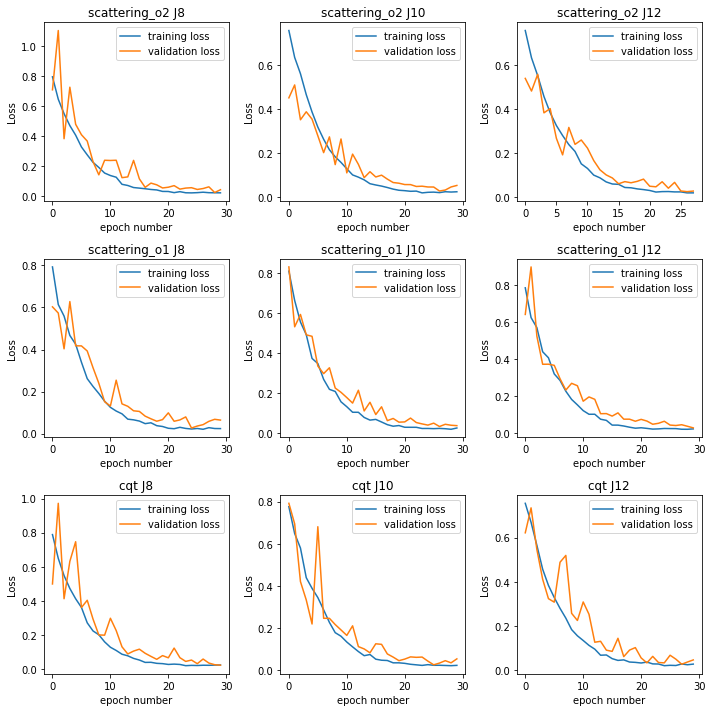

In [7]:
#compare and select optimum J, consider only linear activation, Q = 16
out_dir = "/home/han/wave2shape/output/doce/"
i = 1
plt.subplots(3,3,figsize=(10,10))
for f in ["scattering_o2","scattering_o1","cqt"]:
    for j in [8,10,12]:
        exp = "_".join([f,"J"+str(j),"Q16","bs64","multitaskTrue","linear","log0.001"])
        plt.subplot(3,3,i)
        best_trial = find_best_trial(os.path.join(out_dir,exp))
        plot_loss_curve(os.path.join(out_dir,exp,best_trial,"training.log"),f+" "+"J"+str(j))
        i += 1
plt.tight_layout()


In [8]:
#gather min val loss for all trials per exp, q = 1
   
def gather_minval(exp):
    min_vals = []
    for trial in os.listdir(exp):
        loss = pd.read_csv(os.path.join(exp,trial,"training.log"))
        min_vals.append(min(loss["val_loss"]))
    return min_vals

def prep_histogram_j(output_dir,f,q,js,activation):
    all_minval = []
    for j in js:
        exp_type="_".join(["multitask"+str(True), 
                           "ploss", "alpha", "", "nnbr"+str(""), "linear", "log"+str(0.001)])
        exp_name = "_".join([f,"J"+str(j),"Q"+str(q),"bs"+str(64),exp_type])
        exp = os.path.join(output_dir,exp_name)
        min_vals = np.array(gather_minval(exp))
        all_minval.append(min_vals)
    all_minval = np.stack(all_minval).T
    return all_minval

def prep_histogram_act(output_dir,j,f,q):
    all_minval = []
    for act in ["linear","sigmoid"]:
        exp = "_".join([f,"J"+str(j),"Q"+str(q),"bs64","multitaskTrue",act,"log0.001"])
        exp = os.path.join(output_dir,exp)
        min_vals = np.array(gather_minval(exp))
        all_minval.append(min_vals)
    all_minval = np.stack(all_minval).T
    return all_minval

In [23]:
out_dir = "/home/han/wave2shape/output/doce/"
q = 1
sc_o1 = prep_histogram_j(out_dir,"scattering_o1",q,[8,10],"linear")
cqts = prep_histogram_j(out_dir,"cqt",q,[8,10],"linear")
sc_o2 = prep_histogram_j(out_dir,"scattering_o2",q,[14],"linear")
print(sc_o1.shape,sc_o2.shape,cqts.shape)

(8, 2) (8, 1) (8, 2)


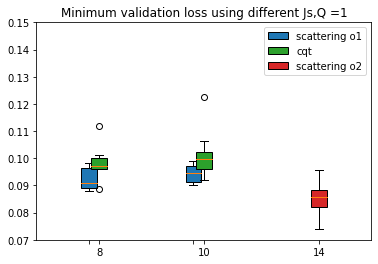

In [25]:
#plot 
labels = ['8','10','14']
gap = 0.1
bp0 = plt.boxplot(sc_o1, labels=["",""], patch_artist=True, positions=[1,2]) #order 1 is (10 by 3)
bp1 = plt.boxplot(cqts, labels=["8","10"], patch_artist=True, positions=[1+gap,2+gap])
bp2 = plt.boxplot(sc_o2, labels=["14"], patch_artist=True, positions=[3+2*gap])


for box in bp0['boxes']:
    box.set(facecolor = 'C0' )

for box in bp1['boxes']:
    box.set(facecolor = 'C2' )

for box in bp2['boxes']:
    box.set(facecolor = 'C3' )
    
plt.title('Minimum validation loss using different Js,Q ='+str(q))#+" J="+str(j))
plt.ylim([0.07,0.15])
plt.legend([bp0["boxes"][0], bp1["boxes"][0],bp2["boxes"][0]], 
           ['scattering o1', 'cqt', 'scattering o2'], loc='upper right')

(8, 2) (8, 1) (8, 2)


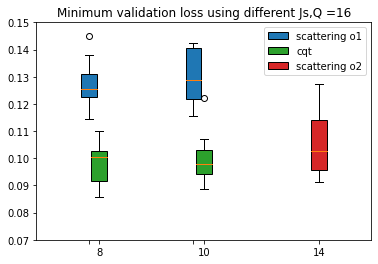

In [26]:
out_dir = "/home/han/wave2shape/output/doce/"
q = 16
sc_o1 = prep_histogram_j(out_dir,"scattering_o1",q,[8,10],"linear")
cqts = prep_histogram_j(out_dir,"cqt",q,[8,10],"linear")
sc_o2 = prep_histogram_j(out_dir,"scattering_o2",q,[14],"linear")
print(sc_o1.shape,sc_o2.shape,cqts.shape)

#plot 
labels = ['8','10','14']
gap = 0.1
bp0 = plt.boxplot(sc_o1, labels=["",""], patch_artist=True, positions=[1,2]) #order 1 is (10 by 3)
bp1 = plt.boxplot(cqts, labels=["8","10"], patch_artist=True, positions=[1+gap,2+gap])
bp2 = plt.boxplot(sc_o2, labels=["14"], patch_artist=True, positions=[3+2*gap])


for box in bp0['boxes']:
    box.set(facecolor = 'C0' )

for box in bp1['boxes']:
    box.set(facecolor = 'C2' )

for box in bp2['boxes']:
    box.set(facecolor = 'C3' )
    
plt.title('Minimum validation loss using different Js,Q ='+str(q))#+" J="+str(j))
plt.ylim([0.07,0.15])
plt.legend([bp0["boxes"][0], bp1["boxes"][0],bp2["boxes"][0]], 
           ['scattering o1', 'cqt', 'scattering o2'], loc='upper right')

In [36]:
def prep_histogram_j_qt(output_dir,f,q,activation):
    all_minval = []
    for j in [8,10]:
        exp_type="_".join(["multitask"+str(True), 
                           "ploss", "alpha", "", "nnbr"+str(""), "linear", "log"+str(0.001)])
        exp_name = "_".join([f,"J"+str(j),"Q"+str(q),"bs"+str(64),exp_type])
        exp = os.path.join(output_dir,exp_name)
        min_vals = np.array(gather_minval(exp))
        all_minval.append(min_vals)
    all_minval = np.stack(all_minval).T
    return all_minval
def prep_histogram_q_qt(output_dir,j,f):
    all_minval = []
    for q in [8,16]:
        exp_type="_".join(["multitask"+str(True), 
                           "ploss", "alpha", "", "nnbr"+str(""), "linear", "log"+str(0.001)])
        exp_name = "_".join([f,"J"+str(j),"Q"+str(q),"bs"+str(64),exp_type])
        exp = os.path.join(output_dir,exp_name)
        
        min_vals = np.array(gather_minval(exp))
        all_minval.append(min_vals)
    all_minval = np.stack(all_minval).T
    return all_minval

In [28]:
out_dir = "/home/han/wave2shape/output/doce/"
q = 8
act = "linear"
vqts = prep_histogram_j_qt(out_dir,"vqt",q,act)
hcqts = prep_histogram_j_qt(out_dir,"hcqt",q,act)
cqts = prep_histogram_j_qt(out_dir,"cqt",q,act)
print(vqts.shape,hcqts.shape,cqts.shape)

(8, 2) (8, 2) (8, 2)


In [31]:
out_dir = "/home/han/wave2shape/output/doce/"
j = 8
act = "linear"
vqts = prep_histogram_q_qt(out_dir,j,"vqt")
hcqts = prep_histogram_q_qt(out_dir,j,"hcqt")
cqts = prep_histogram_q_qt(out_dir,j,"cqt")
print(vqts.shape,hcqts.shape,cqts.shape)

(8, 3) (8, 3) (8, 3)


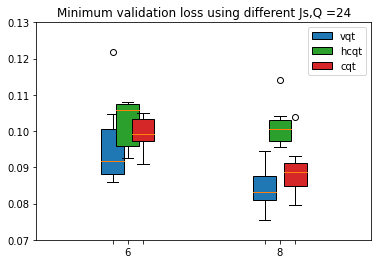

In [66]:
#plot 
labels = ['6','8']
gap = 0.1
bp0 = plt.boxplot(vqts, labels=["",""], patch_artist=True, positions=[1,2]) #order 1 is (10 by 3)
bp1 = plt.boxplot(hcqts, labels=labels, patch_artist=True, positions=[1+gap,2+gap])
bp2 = plt.boxplot(cqts, labels=["",""], patch_artist=True, positions=[1+2*gap,2+2*gap])


for box in bp0['boxes']:
    # change outline color
    #box.set(color='black', linewidth=2)
    # change fill color
    box.set(facecolor = 'C0' )
    # change hatch
    #box.set(hatch = '/')

for box in bp1['boxes']:
    #box.set(color='black', linewidth=2)
    box.set(facecolor = 'C2' )

for box in bp2['boxes']:
    #box.set(color='black', linewidth=2)
    box.set(facecolor = 'C3' )
    
#plt.title('Minimum validation loss using J,Q ='+str(q)+" "+act)
plt.title('Minimum validation loss using different Js,Q ='+str(q))#+" J="+str(j))
plt.ylim([0.07,0.13])
plt.legend([bp0["boxes"][0], bp1["boxes"][0],bp2["boxes"][0]], ['vqt', 'hcqt', 'cqt'], loc='upper right')

(8, 3) (8, 3) (8, 3)


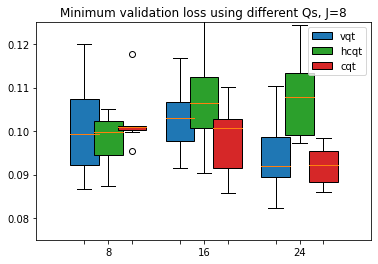

In [33]:
out_dir = "/home/han/wave2shape/output/doce/"
j = 8
act = "linear"
vqts = prep_histogram_q_qt(out_dir,j,"vqt")
hcqts = prep_histogram_q_qt(out_dir,j,"hcqt")
cqts = prep_histogram_q_qt(out_dir,j,"cqt")
print(vqts.shape,hcqts.shape,cqts.shape)

#plot 
labels = ['8','16','24']
gap = 0.25
bp0 = plt.boxplot(vqts, labels=["","",""], patch_artist=True, positions=[1,2,3]) #order 1 is (10 by 3)
bp1 = plt.boxplot(hcqts, labels=labels, patch_artist=True, positions=[1+gap,2+gap,3+gap])
bp2 = plt.boxplot(cqts, labels=["","",""], patch_artist=True, positions=[1+2*gap,2+2*gap,3+2*gap])


for box in bp0['boxes']:
    # change outline color
    #box.set(color='black', linewidth=2)
    # change fill color
    box.set(facecolor = 'C0' )
    # change hatch
    #box.set(hatch = '/')

for box in bp1['boxes']:
    #box.set(color='black', linewidth=2)
    box.set(facecolor = 'C2' )

for box in bp2['boxes']:
    #box.set(color='black', linewidth=2)
    box.set(facecolor = 'C3' )
    
#plt.title('Minimum validation loss using J,Q ='+str(q)+" "+act)
plt.title('Minimum validation loss using different Qs,'+" J="+str(j))
plt.ylim([0.075,0.125])
plt.legend([bp0["boxes"][0], bp1["boxes"][0],bp2["boxes"][0]], ['vqt', 'hcqt', 'cqt'], loc='upper right')

(8, 2) (8, 2) (8, 2)


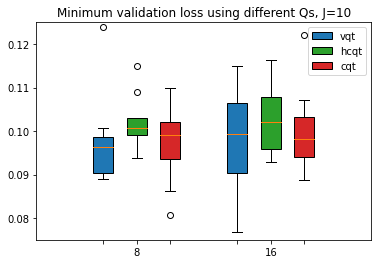

In [39]:
out_dir = "/home/han/wave2shape/output/doce/"
j = 10
act = "linear"
vqts = prep_histogram_q_qt(out_dir,j,"vqt")
hcqts = prep_histogram_q_qt(out_dir,j,"hcqt")
cqts = prep_histogram_q_qt(out_dir,j,"cqt")
print(vqts.shape,hcqts.shape,cqts.shape)

#plot 
labels = ['8','16']
gap = 0.25
bp0 = plt.boxplot(vqts, labels=["",""], patch_artist=True, positions=[1,2]) #order 1 is (10 by 3)
bp1 = plt.boxplot(hcqts, labels=labels, patch_artist=True, positions=[1+gap,2+gap])
bp2 = plt.boxplot(cqts, labels=["",""], patch_artist=True, positions=[1+2*gap,2+2*gap])


for box in bp0['boxes']:
    # change outline color
    #box.set(color='black', linewidth=2)
    # change fill color
    box.set(facecolor = 'C0' )
    # change hatch
    #box.set(hatch = '/')

for box in bp1['boxes']:
    #box.set(color='black', linewidth=2)
    box.set(facecolor = 'C2' )

for box in bp2['boxes']:
    #box.set(color='black', linewidth=2)
    box.set(facecolor = 'C3' )
    
#plt.title('Minimum validation loss using J,Q ='+str(q)+" "+act)
plt.title('Minimum validation loss using different Qs,'+" J="+str(j))
plt.ylim([0.075,0.125])
plt.legend([bp0["boxes"][0], bp1["boxes"][0],bp2["boxes"][0]], ['vqt', 'hcqt', 'cqt'], loc='upper right')

In [39]:
act = "linear"
q=8
order1 = prep_histogram_j(out_dir,"scattering_o1",q,act)
order2 = prep_histogram_j(out_dir,"scattering_o2",q,act)
cqts = prep_histogram_j(out_dir,"cqt",q,act)

In [53]:
j=12
q=16
order1 = prep_histogram_act(out_dir,j,"scattering_o1",q)
order2 = prep_histogram_act(out_dir,j,"scattering_o2",q)
cqts = prep_histogram_act(out_dir,j,"cqt",q)

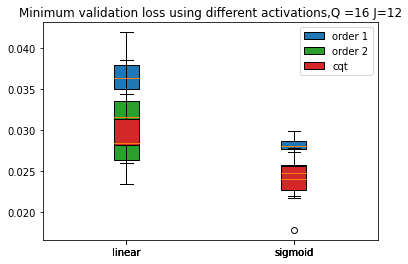

In [54]:
#plot 
labels = ["linear","sigmoid"] #['8','10','12']
bp0 = plt.boxplot(order1, labels=labels, patch_artist=True) #order 1 is (10 by 3)
bp1 = plt.boxplot(order2, labels=labels, patch_artist=True)
bp2 = plt.boxplot(cqts, labels=labels, patch_artist=True)


for box in bp0['boxes']:
    # change outline color
    #box.set(color='black', linewidth=2)
    # change fill color
    box.set(facecolor = 'C0' )
    # change hatch
    #box.set(hatch = '/')

for box in bp1['boxes']:
    #box.set(color='black', linewidth=2)
    box.set(facecolor = 'C2' )

for box in bp2['boxes']:
    #box.set(color='black', linewidth=2)
    box.set(facecolor = 'C3' )
    
#plt.title('Minimum validation loss using J,Q ='+str(q)+" "+act)
plt.title('Minimum validation loss using different activations,Q ='+str(q)+" J="+str(j))

plt.legend([bp0["boxes"][0], bp1["boxes"][0],bp2["boxes"][0]], ['order 1', 'order 2', 'cqt'], loc='upper right')

In [19]:
np.min(cqts),np.min(order1),np.min(order2)

(0.0213211365044116, 0.0171221327036619, 0.0178660135716199)

In [22]:
np.min(cqts),np.min(order1),np.min(order2)

(0.0224378518760204, 0.0269857123494148, 0.0225680638104677)

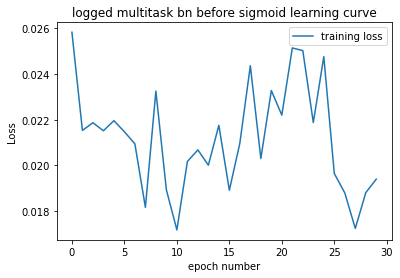

In [13]:
loss_path = "../src/cqt_J12_Q16_bs64_multitask_log_bnoutput/best_models/training.log"
plot_loss_curve(loss_path,title="logged multitask bn before sigmoid learning curve")

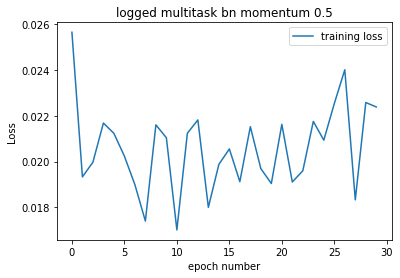

In [14]:
loss_path = "../src/cqt_J12_Q16_bs64_multitask_log_bndebug/best_models/training.log"
plot_loss_curve(loss_path,title="logged multitask bn momentum 0.5")

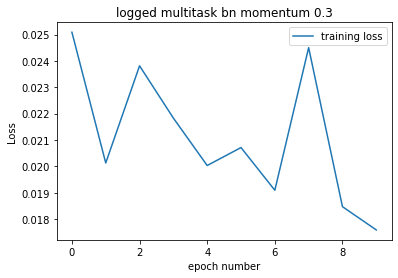

In [15]:
loss_path = "../src/cqt_J12_Q16_bs64_multitask_log_bnmom03/best_models/training.log"
plot_loss_curve(loss_path,title="logged multitask bn momentum 0.3")

In [18]:
import pickle
def get_feat(ftype,fold_str,J,Q,pickle_dir):
    pickle_name = "_".join([ftype,"fold-"+str(fold_str),"J-" + str(J).zfill(2), "Q-" + str(Q).zfill(2)])
    pickle_path = os.path.join(pickle_dir,ftype,pickle_name + ".pkl")
    reader = open(pickle_path,'rb')
    Sy,y = pickle.load(reader) 
    return Sy,y
J = 12
Q = 16
audio_path = "/home/han/data/drum_data/"
pickle_dir = os.path.join(audio_path, "han2022features-pkl")
ftype="scattering_o1"

Sy_train,y_train = get_feat(ftype,"train",J,Q,pickle_dir)
Sy_test, y_test = get_feat(ftype,"test",J,Q,pickle_dir)

In [21]:
eps=1e-5
Sy_train_log = np.log1p(((Sy_train>0)*Sy_train)/eps)
Sy_test_log = np.log1p((Sy_test>0)*Sy_test/eps)

In [23]:
Sy_train_log.shape,Sy_test_log.shape

((82224, 32, 161), (10000, 32, 161))

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(Sy_train_log.reshape(Sy_train_log.shape[0],
                                                  Sy_train_log.shape[1]*Sy_train_log.shape[2]))
Sy_train_scaled = scaler.transform(Sy_train_log.reshape(Sy_train_log.shape[0],
                                                  Sy_train_log.shape[1]*Sy_train_log.shape[2])).reshape(Sy_train_log.shape)
Sy_test_scaled = scaler.transform(Sy_test_log.reshape(Sy_test_log.shape[0],
                                                  Sy_test_log.shape[1]*Sy_test_log.shape[2])).reshape(Sy_test_log.shape)


In [30]:
np.mean(Sy_train_scaled),np.var(Sy_train_scaled),np.mean(Sy_train_log),np.var(Sy_train_log)

(-2.090682e-09, 0.99980617, 1.2179848, 4.411386)

In [31]:
np.mean(Sy_test_scaled),np.var(Sy_test_scaled),np.mean(Sy_test_log),np.var(Sy_test_log)

(0.13490395, 949201.94, 1.2164226, 4.4036026)

In [20]:
def preprocess_feat(Sy_train,Sy_test,Sy_val,eps):
    #logscale
    Sy_train_log = np.log1p(((Sy_train>0)*Sy_train)/eps).reshape(Sy_train.shape[0],
                                                                Sy_train.shape[1]*Sy_train.shape[2])
    Sy_val_log = np.log1p(((Sy_val>0)*Sy_val)/eps).reshape(Sy_val.shape[0],
                                                          Sy_val.shape[1]*Sy_val.shape[2])
    Sy_test_log = np.log1p((Sy_test>0)*Sy_test/eps).reshape(Sy_test.shape[0],
                                                           Sy_test.shape[1]*Sy_test.shape[2])
    #normalize
    scaler = preprocessing.StandardScaler().fit(Sy_train_log)
    Sy_train_scaled = scaler.transform(Sy_train_log).reshape(Sy_train.shape)
    Sy_test_scaled = scaler.transform(Sy_test_log).reshape(Sy_test.shape)
    Sy_val_scaled = scaler.transform(Sy_val_log).reshape(Sy_val.shape)
    
    return Sy_train_scaled,Sy_test_scaled,Sy_val_scaled


Sy_train.shape, Sy_test.shape

((82224, 32, 161), (10000, 32, 161))

In [14]:
#if predict everything to be zero, what the 
naive_pred_1 = np.ones(y_val_normalized.shape)*0.5
naive_pred_0 = np.zeros(y_val_normalized.shape)
print(np.mean((naive_pred_1-y_val_normalized)**2),np.mean((naive_pred_0-y_val_normalized)**2))
naive_pred_1 = np.ones(y_test_normalized.shape)
naive_pred_0 = np.zeros(y_test_normalized.shape)
print(np.mean((naive_pred_1-y_test_normalized)**2),np.mean((naive_pred_0-y_test_normalized)**2))

0.030001999593430938 0.28347868989845737
0.33179852061043275 0.34393119120800913


In [8]:
#make a example input
example_str = test_training.feature_sampler(train_ids,"train",y_train_normalized,0,audio_path,J,Q,ftype)
for samp in example_str.iterate():
    ex_input = samp["input"]
    break

/home/han/miniconda3/envs/py38/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=512 is too small for input signal of length=256
  return f(*args, **kwargs)
/home/han/miniconda3/envs/py38/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=256
  return f(*args, **kwargs)


In [36]:
exp_name = "cqt_J12_Q16_bs64_omega_only"
freqs = librosa.cqt_frequencies(n_bins=J*Q,fmin=0.4*sr*2**(-J),bins_per_octave=Q)
model = cnn.create_model_conv2d_onetask(n_oct=J,bins_per_oct=Q,S=ex_input[None,:],is_centroid=False,vector=None)
ckpt_path = "../src/" + exp_name + "/best_models/ckpt"
test_idx = np.arange(0,y_test.shape[0],1)
test_batches = test_training.data_generator(test_ids,
                                   "test",
                                y_test_normalized, 
                                {"type":"cqt","J":12,"Q":16},
                                audio_path,
                                batch_size=bs, 
                                idx=test_idx,
                                active_streamers=32,
                                rate=64,
                                random_state=random_state)
preds2 = yield_prediction(test_batches,ckpt_path,model)

100/100 [==============================] - 18s 176ms/step


In [14]:
exp_name = "cqt_J12_Q16_bs64_multitask"
freqs = librosa.cqt_frequencies(n_bins=J*Q,fmin=0.4*sr*2**(-J),bins_per_octave=Q)
model = cnn.create_model_conv2d(n_oct=J,bins_per_oct=Q,S=ex_input[None,:])
ckpt_path = "../src/" + exp_name + "/best_models/ckpt"
test_idx = np.arange(0,y_test.shape[0],1)
test_batches = test_training.data_generator(test_ids,
                                   "test",
                                y_test_normalized, 
                                {"type":"cqt","J":12,"Q":16},
                                audio_path,
                                batch_size=bs, 
                                idx=test_idx,
                                active_streamers=32,
                                rate=64,
                                random_state=random_state)
preds = yield_prediction(test_batches,ckpt_path,model)


/home/han/miniconda3/envs/py38/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=512 is too small for input signal of length=256
  return f(*args, **kwargs)
/home/han/miniconda3/envs/py38/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=256
  return f(*args, **kwargs)


100/100 [==============================] - 18s 176ms/step


In [21]:
exp_name = "cqt_J12_Q16_bs64_multitask_bnoutput"
freqs = librosa.cqt_frequencies(n_bins=J*Q,fmin=0.4*sr*2**(-J),bins_per_octave=Q)
model = cnn.create_model_conv2d(n_oct=J,bins_per_oct=Q,S=ex_input[None,:])
ckpt_path = "../src/" + exp_name + "/best_models/ckpt"
test_idx = np.arange(0,y_test.shape[0],1)
test_batches = test_training.data_generator(test_ids,
                                   "test",
                                y_test_normalized, 
                                {"type":"cqt","J":12,"Q":16},
                                audio_path,
                                batch_size=bs, 
                                idx=test_idx,
                                active_streamers=32,
                                rate=64,
                                random_state=random_state)
preds_bnfirst = yield_prediction(test_batches,ckpt_path,model)


/home/han/miniconda3/envs/py38/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=512 is too small for input signal of length=256
  return f(*args, **kwargs)
/home/han/miniconda3/envs/py38/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=256
  return f(*args, **kwargs)


100/100 [==============================] - 8s 78ms/step


In [118]:
exp_name = "cqt_J12_Q16_bs64_multitask_log_bnoutput"
freqs = librosa.cqt_frequencies(n_bins=J*Q,fmin=0.4*sr*2**(-J),bins_per_octave=Q)
model = cnn.create_model_conv2d(n_oct=J,bins_per_oct=Q,S=ex_input[None,:])
ckpt_path = "../src/" + exp_name + "/best_models/ckpt"
test_idx = np.arange(0,y_test.shape[0],1)
test_batches = test_training.data_generator(test_ids,
                                   "test",
                                y_test_normalized, 
                                {"type":"cqt","J":12,"Q":16},
                                audio_path,
                                batch_size=bs, 
                                idx=test_idx,
                                active_streamers=32,
                                rate=64,
                                random_state=random_state)
preds_log_bnfirst = yield_prediction(test_batches,ckpt_path,model)


/home/han/miniconda3/envs/py38/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=512 is too small for input signal of length=256
  return f(*args, **kwargs)
/home/han/miniconda3/envs/py38/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=256
  return f(*args, **kwargs)


100/100 [==============================] - 18s 176ms/step


In [42]:
exp_name = "cqt_J12_Q16_bs64_multitask_log_bndebug"
freqs = librosa.cqt_frequencies(n_bins=J*Q,fmin=0.4*sr*2**(-J),bins_per_octave=Q)
model = cnn.create_model_conv2d(n_oct=J,bins_per_oct=Q,S=ex_input[None,:])
ckpt_path = "../src/" + exp_name + "/best_models/ckpt"
test_idx = np.arange(0,y_test.shape[0],1)
test_batches = test_training.data_generator(test_ids,
                                   "test",
                                y_test_normalized, 
                                {"type":"cqt","J":12,"Q":16},
                                audio_path,
                                batch_size=1, 
                                idx=test_idx,
                                active_streamers=32,
                                rate=64,
                                random_state=random_state)
preds_log_bndebug = yield_prediction(test_batches,ckpt_path,model)


/home/han/miniconda3/envs/py38/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=512 is too small for input signal of length=256
  return f(*args, **kwargs)
/home/han/miniconda3/envs/py38/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=256
  return f(*args, **kwargs)


100/100 [==============================] - 6s 60ms/step


In [10]:
exp_name = "cqt_J12_Q16_bs64_multitask_log_bnmom099"
freqs = librosa.cqt_frequencies(n_bins=J*Q,fmin=0.4*sr*2**(-J),bins_per_octave=Q)
model = cnn.create_model_conv2d(n_oct=J,bins_per_oct=Q,S=ex_input[None,:])
ckpt_path = "../src/" + exp_name + "/best_models/ckpt"
test_idx = np.arange(0,y_test.shape[0],1)
test_batches = test_training.data_generator(test_ids,
                                   "test",
                                y_test_normalized, 
                                {"type":"cqt","J":12,"Q":16},
                                audio_path,
                                batch_size=bs, 
                                idx=test_idx,
                                active_streamers=32,
                                rate=64,
                                random_state=random_state)
preds_log_bnmom099 = yield_prediction(test_batches,ckpt_path,model)


100/100 [==============================] - 17s 174ms/step


(array([[4332.,  858.,  656.,  315.,   34.,    0.,   55.,   79.,   71.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.],
        [   0.,    0.,  178.,    0.,   77.,   53.,    0.,   59.,   11.,
           15.,   62.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,   72.,    0.,   64.,  144.,   62.,   83.,
          176.,  740., 4604.],
        [1768., 1131.,  607.,  744.,  458.,  445.,  165.,  209.,   62.,
           76.,   36.,    0.,  116.,   85.,  270.,    0.,  115.,    0.,
          113.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.],
        [4228.,  629.,  390.,  187.,  172.,    0.,   62.,   18.,  135.,
            0.,    0.,    0.,   73.,  146.,   58.,  116.,    0.,    0.,
            0.,    0.,    0.,    0.,   52.,   68.,    0.,    0.,   66.,
            0.,    0.,    0.],
        [  5

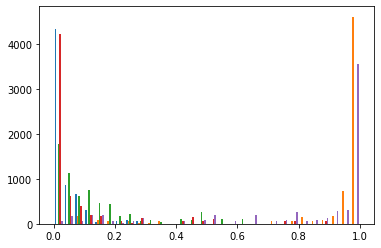

In [11]:
plt.hist(preds_log_bnmom099,bins=30)

(array([[268., 153., 376., 459., 313., 264., 123.,   0.,  62., 125., 209.,
          63.,   0.,  78.,  20.,   0.,  89., 177., 146., 201., 208., 363.,
         113., 258., 353.,  82., 112., 556., 445., 784.],
        [  0.,   0., 135., 299.,  95., 619., 127., 253., 197., 182.,   0.,
         134., 345., 286., 105., 103., 361., 182., 129., 265., 528., 266.,
         181., 441.,  75., 157., 210., 370.,  69., 286.],
        [175., 187., 307., 176., 520.,  88., 386., 128., 118., 299., 141.,
         520., 194., 428., 617., 189., 555., 216., 254.,  96., 193., 220.,
          94., 169., 130.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,  72.,  64., 126.,  57.,  47.,   0., 166.,   0.,
         165., 204.,  74., 147., 129., 335., 429.,  91., 268., 341., 308.,
         630., 634., 413., 504., 412., 312., 280., 192.],
        [  0.,   0.,   0.,  72., 179., 121., 400., 131., 116., 303., 253.,
         363., 525., 229., 519., 378., 486., 427., 602., 515., 187., 289.,
         132.,   0

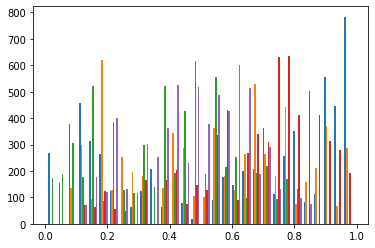

In [9]:
plt.hist(preds_log_nobn,bins=30)

(array([ 5.,  0.,  1.,  2.,  0.,  3.,  0.,  0.,  0.,  4.,  0., 11.,  7.,
         0.,  2.,  0.,  2.,  3., 13.,  6.,  9.,  6.,  1.,  5.,  7.,  0.,
         4.,  0.,  2.,  7.]),
 array([0.13210046, 0.15825756, 0.18441464, 0.21057174, 0.23672883,
        0.26288593, 0.289043  , 0.3152001 , 0.3413572 , 0.36751428,
        0.39367136, 0.41982847, 0.44598556, 0.47214264, 0.49829975,
        0.52445686, 0.55061394, 0.576771  , 0.6029281 , 0.6290852 ,
        0.65524226, 0.68139935, 0.7075565 , 0.73371357, 0.75987065,
        0.7860277 , 0.8121848 , 0.83834195, 0.86449903, 0.8906561 ,
        0.9168132 ], dtype=float32),
 <BarContainer object of 30 artists>)

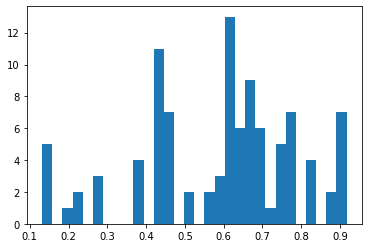

In [48]:
plt.hist(preds_log_bndebug[:,0],bins=30)

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 257, 1)]     0         
                                                                 
 batch_normalization (BatchN  (None, 192, 257, 1)      4         
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 192, 32, 1)       0         
 ooling2D)                                                       
                                                                 
 conv1 (Conv2D)              (None, 192, 32, 128)      16512     
                                                                 
 batch_normalization_1 (Batc  (None, 192, 32, 128)     512       
 hNormalization)                                                 
                                                             

In [24]:
def plot_intermediate_layer(layer_name,model,test_batches,steps):
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
    intermediate_output = intermediate_layer_model.predict(pescador.tuples(test_batches,'input','y'),
                                                           steps=steps,verbose=1)
    return intermediate_output

In [126]:
layer_name = 'input_6'
intermediate_output = plot_intermediate_layer(layer_name,model,val_batches,steps=10)
print(np.mean(intermediate_output),np.var(intermediate_output))
layer_name = 'batch_normalization_36'
intermediate_output = plot_intermediate_layer(layer_name,model,val_batches,steps=10)
print(np.mean(intermediate_output),np.var(intermediate_output))
layer_name = 'dense_9'
intermediate_output = plot_intermediate_layer(layer_name,model,val_batches,steps=10)
print(np.mean(intermediate_output),np.var(intermediate_output))
layer_name = 'batch_normalization_42'
intermediate_output = plot_intermediate_layer(layer_name,model,val_batches,steps=10)
print(np.mean(intermediate_output),np.var(intermediate_output))

10/10 [==============================] - 1s 54ms/step
17.200245 14.283618
10/10 [==============================] - 2s 221ms/step
3.6703231 1.6867384
10/10 [==============================] - 2s 214ms/step
-14.200037 1402.2728
10/10 [==============================] - 1s 102ms/step
-11.924834 1076.8019


100/100 [==============================] - 19s 192ms/step
8864.105 3627.3904


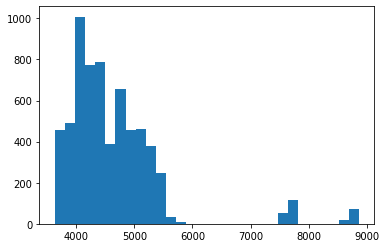

In [80]:
layer_name = 'dense_5'
intermediate_output = plot_intermediate_layer(layer_name,model,test_batches,steps=100)
plt.hist(intermediate_output,bins=30)
print(np.max(intermediate_output),np.min(intermediate_output))

100/100 [==============================] - 19s 193ms/step
8859.677 3625.578


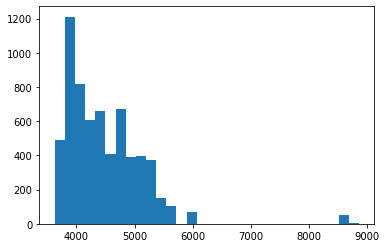

In [81]:
layer_name = 'batch_normalization_19'
intermediate_output = plot_intermediate_layer(layer_name,model,test_batches,steps=100)
plt.hist(intermediate_output,bins=30)
print(np.max(intermediate_output),np.min(intermediate_output))

  4/100 [>.............................] - ETA: 10s

/home/han/miniconda3/envs/py38/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=512 is too small for input signal of length=256
  return f(*args, **kwargs)
/home/han/miniconda3/envs/py38/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=256
  return f(*args, **kwargs)


100/100 [==============================] - 19s 188ms/step
115.74151 -101.97506


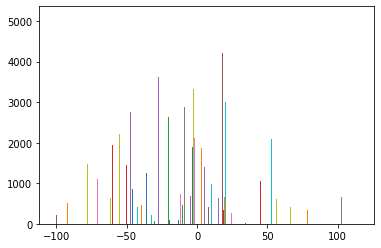

In [62]:
layer_name = 'dense'
intermediate_output = plot_intermediate_layer(layer_name,model,test_batches,steps=100)
plt.hist(intermediate_output,bins=30)
print(np.max(intermediate_output),np.min(intermediate_output))

100/100 [==============================] - 19s 188ms/step
61.931538 -80.03821


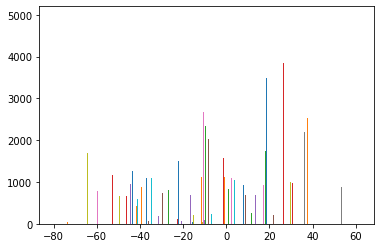

In [63]:
layer_name = 'batch_normalization_5'
intermediate_output = plot_intermediate_layer(layer_name,model,test_batches,steps=100)
plt.hist(intermediate_output,bins=30)
print(np.max(intermediate_output),np.min(intermediate_output))

/home/han/miniconda3/envs/py38/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=512 is too small for input signal of length=256
  return f(*args, **kwargs)
/home/han/miniconda3/envs/py38/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=256
  return f(*args, **kwargs)


10/10 [==============================] - 1s 95ms/step
37.937492 -66.55425


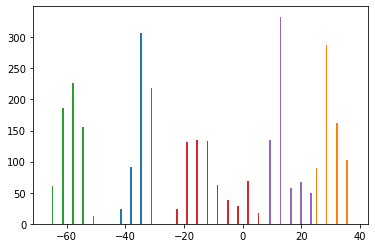

In [50]:
val_idx = np.arange(0,y_val.shape[0],1)
val_batches = test_training.data_generator(val_ids,
                                   "val",
                                y_val_normalized, 
                                {"type":"cqt","J":12,"Q":16},
                                audio_path,
                                batch_size=bs, #64
                                idx=val_idx,
                                active_streamers=32,
                                rate=64,
                                random_state=random_state)
layer_name = 'batch_normalization_6'
intermediate_output = plot_intermediate_layer(layer_name,model,val_batches,steps=10)
plt.hist(intermediate_output,bins=30)
print(np.max(intermediate_output),np.min(intermediate_output))

In [49]:
np.mean(intermediate_output[0,:]),np.var(intermediate_output[0,:])

(-7.3009734, 1055.9338)

In [37]:
bn_6 = model.get_layer("batch_normalization_6")

In [38]:
bn_6.weights

[<tf.Variable 'batch_normalization_6/gamma:0' shape=(5,) dtype=float32, numpy=
 array([1.0331345, 1.029744 , 1.0205534, 1.0126147, 1.0223057],
       dtype=float32)>,
 <tf.Variable 'batch_normalization_6/beta:0' shape=(5,) dtype=float32, numpy=
 array([ 0.01977281, -0.03587963,  0.02342267,  0.03236252,  0.04130504],
       dtype=float32)>,
 <tf.Variable 'batch_normalization_6/moving_mean:0' shape=(5,) dtype=float32, numpy=
 array([ 0.27872616,  0.21592171, -0.24144734, -0.08009179, -0.30266854],
       dtype=float32)>,
 <tf.Variable 'batch_normalization_6/moving_variance:0' shape=(5,) dtype=float32, numpy=
 array([2.0499249 , 1.4817157 , 1.2125123 , 0.9885448 , 0.96924806],
       dtype=float32)>]

In [ ]:
layer_name = 'batch_normalization_6'
intermediate_output = plot_intermediate_layer(layer_name,model,test_batches,steps=100)
plt.hist(intermediate_output,bins=30)
print(np.max(intermediate_output),np.min(intermediate_output))

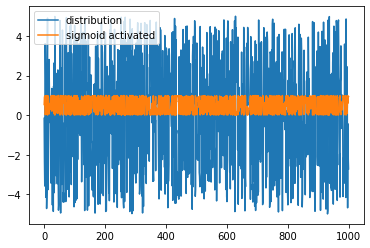

In [35]:
##random vector
dist = (np.random.rand(1000)-0.5)*10 #(when distribution is within -5 to 5 will the activated output cover 0-1)
#apply sigmoid
act_dist = 1/(1+np.exp(dist))
#visualize difference
plt.plot(dist,label="distribution")
plt.plot(act_dist,label= "sigmoid activated")
plt.legend()
plt.show()

In [86]:
nfreq=192
ntime=257
nchan_in=1
S_input_shape = (nfreq,ntime,nchan_in) #(naudio,nfreq,ntime,nchan_in)
S_input = keras.layers.Input(shape=S_input_shape)

x = BatchNormalization()(S_input)
model = Model(inputs=[S_input], outputs=x)
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [115]:
x = np.random.rand(nfreq,ntime,3)
x_norm = BatchNormalization(axis=-1)(x,training=True)
x.shape

(192, 257, 3)

In [116]:
x = x.reshape((192*257,3))
x_norm = x_norm.numpy().reshape((192*257,3))

In [117]:
np.mean(x,axis=0),np.var(x,axis=0),np.mean(x_norm,axis=0),np.var(x_norm,axis=0)

(array([0.49957085, 0.49961356, 0.49900303]),
 array([0.08282849, 0.08391524, 0.08349107]),
 array([ 1.4956726e-08, -1.6664031e-07, -7.3969481e-08], dtype=float32),
 array([0.98806965, 0.9882197 , 0.9881557 ], dtype=float32))

(array([ 61.,  57.,   0.,  41.,  73., 121., 324.,  38., 136., 285., 160.,
         36.,  77.,  68.,  49.,   0., 171., 298., 268., 436., 446., 497.,
        399., 763., 626., 443., 354.,  70.,  49.,  54.]),
 array([-45.84015 , -45.226017, -44.61189 , -43.997757, -43.38363 ,
        -42.769497, -42.15537 , -41.541237, -40.92711 , -40.312977,
        -39.69885 , -39.084717, -38.47059 , -37.856457, -37.24233 ,
        -36.628197, -36.01407 , -35.399937, -34.78581 , -34.171677,
        -33.55755 , -32.943417, -32.32929 , -31.715157, -31.101027,
        -30.486897, -29.872766, -29.258636, -28.644506, -28.030376,
        -27.416246], dtype=float32),
 <BarContainer object of 30 artists>)

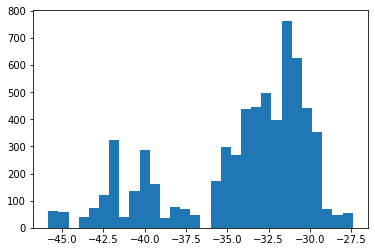

In [21]:
#manually do sigmoid activation
plt.hist(intermediate_output[:,0],bins=30)

100/100 [==============================] - 18s 183ms/step
1.0 1.169961e-31


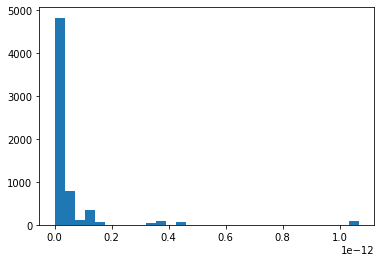

In [22]:
layer_name = 'activation_5'
intermediate_output = plot_intermediate_layer(layer_name,model,test_batches,steps=100)
plt.hist(intermediate_output[:,0],bins=30)
print(np.max(intermediate_output),np.min(intermediate_output))

0.030494994 -0.0932695


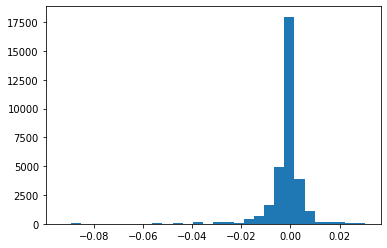

In [27]:
plt.hist(intermediate_output.flatten(),bins=30)
print(np.max(intermediate_output),np.min(intermediate_output))

0.031776458 -0.109918155


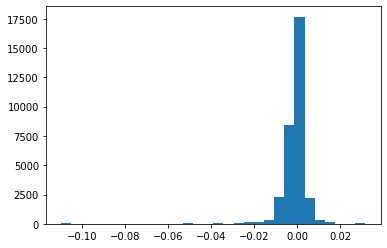

In [32]:
plt.hist(intermediate_output2.flatten(),bins=30)
print(np.max(intermediate_output2),np.min(intermediate_output2))

1.0 0.0


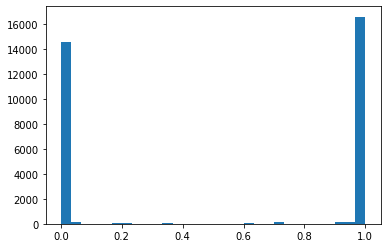

In [70]:
plt.hist(preds.flatten(),bins=30)
print(np.max(preds),np.min(preds))

1.0 1.0


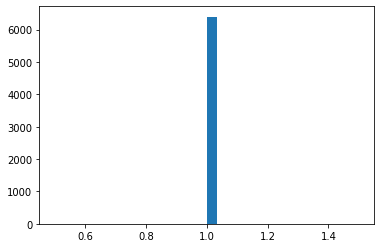

In [77]:
plt.hist(preds2,bins=30)
print(np.max(preds2),np.min(preds2))

drafts

In [ ]:
X = []
i = 0
for idx in range(len(test_ids)):
    example_str = test_training.feature_sampler(test_ids,"test",y_test_normalized,idx,audio_path,J,Q,ftype)
    for samp in example_str.iterate():
        X.append(samp["input"])
        break
    i+=1
    if i>=20:
        break
X = np.stack(X)

In [ ]:
#reduce_sum is more reliable when calculating 1 norm. 
a = np.random.rand(2,2,2)
a,tf.reduce_sum(a,axis=[0,1],keepdims=True),np.sum(np.sum(a,axis=0),axis=0),tf.linalg.norm(a,ord=1,axis=[0,1]),tf.linalg.norm(a,ord=1)
